## Power Masternodes

First, load everthing at once.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

from etherscan import Etherscan

import json
import time
import os
import random
import math

import scipy.stats as st


print(pd.__version__)
print(np.__version__)
print(requests.__version__)
print(plt.matplotlib.__version__)


# https://martin-thoma.com/configuration-files-in-python/

import json

with open("../../3_api/.private/keys.json") as keys_file:
    KEYS = json.load(keys_file)

# Note: don't print the key, or if you do, delete the cell's output
# (cell outputs are saved and can be sent to Github).


## DEEPDAO

def deepdao(query, params=None, post=False):

    ENDPOINT = 'https://api.deepdao.io/v0.1/'

    headers={
        'x-api-key': KEYS['DEEPDAO'],
        'accept': 'application/json'
    }

    if post:
        response = requests.post(ENDPOINT + query,
                                headers=headers,
                                json=params)
    else:
        response = requests.get(ENDPOINT + query,
                                headers=headers,
                                params=params)

    print(response)
    return response.json()

## ETHERSCAN
############

def etherscan(params={}):

    ENDPOINT = 'https://api.etherscan.io/api'

    params['apikey'] = KEYS['ETHERSCAN']

    response = requests.get(ENDPOINT,
                            headers={
                                'accept': 'application/json',
                                "User-Agent": ""
                            },
                            params=params)

    print(response)
    return response.json()


eth = Etherscan(KEYS['ETHERSCAN'])

## SNAPSHOT
###########

SNAPSHOT_ENDPOINT = "https://hub.snapshot.org/graphql"

snapshot = Client(
    transport=AIOHTTPTransport(url=SNAPSHOT_ENDPOINT)
)


def snapshot_rest(query, params=None):

    response = requests.post(SNAPSHOT_ENDPOINT,
                            headers={                      
                                'accept': 'application/json'
                            },
                            params={
                                'query': query
                            })

    print(response)
    return response.json()['data']

## THE GRAPH
############

## Endpoints depends on subgraph of interest.


def pd_read_json(file):
    ## Prevents Value too big Error.
    with open(file) as f:
        df = json.load(f)
    df = pd.DataFrame(df)
    return df


def get_query(filename, do_gql=False):
    with open("gql_queries/" + filename.replace(".gql", "") + ".gql") as f:
        query = f.read()
        if do_gql: query = gql(query)
    return query
    
## Alias gq.
gq = get_query


def get_query(filename, do_gql=False):
    with open("gql_queries/" + filename.replace(".gql", "") + ".gql") as f:
        query = f.read()
        if do_gql: query = gql(query)
    return query
    
## Alias gq.
gq = get_query

async def gql_all(query, field, first=1000, skip=None, initial_list=None, 
                  counter = True, limit=None, save=None, save_interval=10, clear_on_save = False, append=True, rest=False, data_dir="data", save_counter = 1, vars=None):

    ## The returned value and the varible used to accumulate results.
    out = []

    ## Utility function to save intermediate and final results.
    def save_json():

        # Pandas has problem load pure json saves.
        # Hence we create a pandas Dataframe and save it.
        # nonlocal append
        # flag = "a" if append else "w"
        # with open("data/" + save, flag) as f:
        #     json.dump(out, f)
        #     print("Saved.")

        nonlocal out
        df = pd.DataFrame(out)

        if clear_on_save:
            
            nonlocal save_counter
            
            sv = str(save_counter)
            sv = sv.zfill(5)
            save_counter += 1

            filename = save.replace('.json', '_' + sv + '.json')
            
            out = []
            out_str = "Saved and cleared."
        else:
            filename = save
            out_str = "Saved."
        
        df.to_json(data_dir + "/" + filename, orient="records")
        print(out_str)

        
    ## Load initial list.
    ## If no skip is provided, then skip is set to the length of
    ## the initial list, otherwise we use the user-specified value
    if initial_list:
        out = initial_list
        if skip is None:
            skip = len(out)
    elif skip is None:
        skip = 0

    ## Make a GQL query object, if necessary.
    if not rest and type(query) == str:
        query = gql(query)
        

    my_counter = 0
    fetch = True
    try:
        while fetch:
            
            my_counter += 1
            if limit and my_counter > limit:
                print('**Limit reached: ', limit)
                fetch = False
                continue

            if rest:

                # Building query manually.
                q = query.replace("($first: Int!, $skip: Int!)", "")
                q = q.replace("$first", str(first))
                q = q.replace("$skip", str(skip))
                # print(q)

                ## Optional additional variables.
                if vars:
                    for v in vars:
                        q = q.replace("$" + v, str(vars[v]))

                res = snapshot_rest(q)
                
            else:
                
                _vars = {"first": first, "skip": skip}
                
                ## Optional additional variables.
                if vars:
                    _vars = _vars | vars

                res = await snapshot.execute_async(query, variable_values=_vars)
            
            if not res[field]:
                print('**I am done fetching!**')
                fetch = False
            else:
                out.extend(res[field])
                skip += first
                if counter: print(my_counter, len(out))

                if save and my_counter % save_interval == 0:
                    save_json()

        if save and my_counter % save_interval != 0:
            save_json()

    except Exception as e:
        print(str(e))
        print("**An error occurred, exiting early.**")
        if save: save_json()
    
    return out

def pd_read_dir(dir, blacklist=None, whitelist=None, ext=('.json')):
    dir_df = pd.DataFrame()
    

    for file in os.listdir(dir):
        if blacklist and file in blacklist:
            continue
        if whitelist and file not in whitelist:
            continue

        if file.endswith(ext):
            tmp_df = pd_read_json(dir + '/' + file)
            dir_df = pd.concat([dir_df, tmp_df])
    
    return dir_df

1.3.1
1.19.4
2.28.1
3.4.2


## Preparing to compute power as in Mosley et al. (2022).

"Towards a systemic understanding of blockchain governance in proposal voting: A dash case study."

Load `spaces`, `proposals`, and `votes`.

In [2]:
spaces = pd_read_json("../data/snapshot_spaces.json")

all_proposals = pd_read_json("../data/snapshot_proposals.json")


In [3]:
## If downloaded already.
all_votes = pd_read_dir("../data/votes")

In [ ]:
## Otherwise.
## This query takes a while...
# votes_query = gq("snapshot_votes")
# res = await gql_all(votes_query, 
#                     field="votes", 
#                     rest=True,
#                     save="snapshot_votes_test.json",
#                     data_dir="data/votes/",
#                     save_interval = 20,
#                     limit=2,
#                     first=20000, # First can be a high number.
#                     clear_on_save=True
#                     )

In [4]:
print("spaces: ", len(spaces))
print("proposals: ", len(all_proposals))
print("votes: ", len(all_votes))

spaces:  11072
proposals:  69266
votes:  5494790


### Cleanup

#### Proposals

In [8]:
all_proposals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69266 entries, 0 to 69265
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  69266 non-null  object 
 1   ipfs                69266 non-null  object 
 2   author              69266 non-null  object 
 3   created             69266 non-null  int64  
 4   space               69266 non-null  object 
 5   network             69266 non-null  object 
 6   symbol              69266 non-null  object 
 7   type                69266 non-null  object 
 8   strategies          69266 non-null  object 
 9   plugins             69266 non-null  object 
 10  title               69266 non-null  object 
 11  body                69266 non-null  object 
 12  discussion          69266 non-null  object 
 13  choices             69266 non-null  object 
 14  start               69266 non-null  int64  
 15  end                 69266 non-null  int64  
 16  quor

In [5]:
all_proposals['space'] = all_proposals['space'].apply(lambda x : x['id'])


In [6]:
all_proposals['space'].head() 

0    balancer.eth
1    balancer.eth
2    balancer.eth
3    balancer.eth
4    balancer.eth
Name: space, dtype: object

#### Votes.

In [6]:
all_votes.head()


,id,ipfs,voter,created,space,proposal,choice,metadata,reason,app,vp,vp_by_strategy,vp_state
0,QmY3RStzfrjtnFUmZvwfriqtobDndKC2v5bY7gGt3yqmdk,QmY3RStzfrjtnFUmZvwfriqtobDndKC2v5bY7gGt3yqmdk,0xfe36132CAa71c4B1A88b38B79373aAb5E001457c,1636888820,{'id': 'pancake'},{'id': '0x8aec905ad562f5a320f7ae7d11d4d3de5eb4...,1,{},,,0.001,[0.001],final
1,QmZh17iC3C8pUD9J9xxCKHwPdtqetbMUyDndd5JdMYkP77,QmZh17iC3C8pUD9J9xxCKHwPdtqetbMUyDndd5JdMYkP77,0xD3815588b090Cd966fA078134517eb091ea5a22c,1636888820,{'id': 'pancake'},{'id': '0x8aec905ad562f5a320f7ae7d11d4d3de5eb4...,1,{},,,0.001,[0.001],final
2,QmbXri9w7yau8mU7J91cRgT3FLNDgaKpm7DbQhESgJnzD6,QmbXri9w7yau8mU7J91cRgT3FLNDgaKpm7DbQhESgJnzD6,0x6e02F9ebcbeA1D919E77d237cD32150d00F41B03,1636888821,{'id': 'pancake'},{'id': '0xc36810958127e4d424b287cf168e972abdc6...,1,{},,,0.001,[0.001],final
3,Qmc885Jdk1qPQLYpWyj2dSSG1azMgCFEtYZrs68tD3uTK5,Qmc885Jdk1qPQLYpWyj2dSSG1azMgCFEtYZrs68tD3uTK5,0x0b0498E4FB7817358fee5B20501DB0cE7e40bA36,1636888821,{'id': 'pancake'},{'id': '0xff8e1a71a0675b8fd96c7828c1df1e0939ac...,1,{},,,0.001,[0.001],final
4,QmdoVaEeaEVC3hnycezMozfQ2gHWCLujcw4bXovaGgtXzz,QmdoVaEeaEVC3hnycezMozfQ2gHWCLujcw4bXovaGgtXzz,0xadEF37Aa14Ef396167982a3c547a0C796C01f28C,1636888821,{'id': 'pancake'},{'id': '0x8aec905ad562f5a320f7ae7d11d4d3de5eb4...,1,{},,,0.001,[0.001],final


In [7]:
all_votes['space'] = all_votes['space'].apply(lambda x : x['id'])


In [8]:
## Returns an error, we need to account for a None field.
# all_votes['proposal'] = all_votes['proposal'].apply(lambda x : x['id'])

all_votes['proposal'] = all_votes['proposal'].apply(lambda x : 
    x if x is None else x['id']
)

#### Pancake Swap

Who did most of the proposals?

In [9]:
most_props = spaces[spaces['proposalsCount'] == max(spaces['proposalsCount'])]
DAO_MOST_PROPS_ID = most_props['id'].iloc[0]
DAO_MOST_PROPS_ID


'pancake'

In [15]:
all_proposals['space'].value_counts()

pancake                     2263
snapshot.dcl.eth            1406
cakevote.eth                1304
frami.eth                    637
huwacoin.eth                 599
                            ... 
0xgene.eth                     1
palladiumfinance.eth           1
bankofryoshideployer.eth       1
saturnworld.eth                1
toshikovault.eth               1
Name: space, Length: 8267, dtype: int64

In [10]:
pancake_props = all_proposals[all_proposals['space'] == DAO_MOST_PROPS_ID ]
pancake_props.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2263 entries, 785 to 67501
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2263 non-null   object 
 1   ipfs                2263 non-null   object 
 2   author              2263 non-null   object 
 3   created             2263 non-null   int64  
 4   space               2263 non-null   object 
 5   network             2263 non-null   object 
 6   symbol              2263 non-null   object 
 7   type                2263 non-null   object 
 8   strategies          2263 non-null   object 
 9   plugins             2263 non-null   object 
 10  title               2263 non-null   object 
 11  body                2263 non-null   object 
 12  discussion          2263 non-null   object 
 13  choices             2263 non-null   object 
 14  start               2263 non-null   int64  
 15  end                 2263 non-null   int64  
 16  quo

In [11]:
pancake_votes = all_votes[all_votes['space'] == DAO_MOST_PROPS_ID ]
pancake_votes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100529 entries, 0 to 16262
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              100529 non-null  object
 1   ipfs            100529 non-null  object
 2   voter           100529 non-null  object
 3   created         100529 non-null  int64 
 4   space           100529 non-null  object
 5   proposal        100529 non-null  object
 6   choice          100529 non-null  object
 7   metadata        100529 non-null  object
 8   reason          100529 non-null  object
 9   app             100529 non-null  object
 10  vp              100529 non-null  object
 11  vp_by_strategy  100529 non-null  object
 12  vp_state        100529 non-null  object
dtypes: int64(1), object(12)
memory usage: 10.7+ MB


In [17]:
## Generate an error, there are mixed types.
pancake_votes['choice'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


1                     97867
2                      1707
3                       319
[1]                     155
4                       116
                      ...  
[2, 3, 1, 4]              1
[1, 4, 8, 7]              1
[8, 1, 2, 3, 5, 7]        1
[1, 2, 3, 4, 8, 7]        1
[2, 1, 3, 4, 5]           1
Name: choice, Length: 110, dtype: int64

In [12]:
pancake_votes['choice'].describe()

count     100529
unique       110
top            1
freq       97867
Name: choice, dtype: int64

Let's remove non 'int' votes (e.g., ranked choices).

In the real analysis we should try to analyze all data.

In [13]:
print(len(pancake_votes))
pancake_votes = pancake_votes[pancake_votes['choice'].isin([1,2,3])]
print(len(pancake_votes))

100529
99893


In [14]:
pancake_votes['choice'].value_counts()

1    97867
2     1707
3      319
Name: choice, dtype: int64

Let's center them around zero.

In [15]:
pancake_votes['choice'] = pancake_votes['choice'] - 2
pancake_votes['choice'].value_counts()

-1    97867
 0     1707
 1      319
Name: choice, dtype: int64

How much a node deviate from the others in every proposal.

In [22]:
def euclid(row):
    vote = row['choice']
    proposal = row['proposal']
    other_votes = pancake_votes[pancake_votes['proposal'] == proposal]
    distances = other_votes['choice'].apply(lambda x: math.pow((vote - x), 2))
    return math.sqrt(sum(distances))


pancake_votes['vote_distance'] = pancake_votes.apply(euclid, axis=1)

In [23]:
pancake_votes['vote_distance'].describe()


count    99893.000000
mean         0.932962
std          1.948018
min          0.000000
25%          0.000000
50%          0.000000
75%          1.414214
max         65.795137
Name: vote_distance, dtype: float64

<AxesSubplot:ylabel='Frequency'>

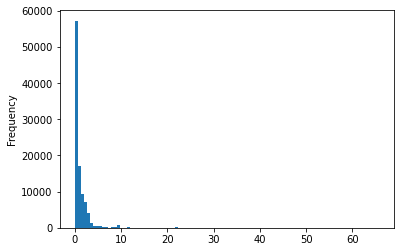

In [24]:
pancake_votes['vote_distance'].plot.hist(bins=100)

In [28]:
pancake_prop_groups = pancake_votes.groupby('proposal')


,count,mean,std,min,25%,50%,75%,max
proposal,,,,,,,,
0x815fcd64997bb3c091e892662a70367c1e86a84de3b5509c26b3785676d66a85,802.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0x66bafc65f718115ce06b06199d2996456574d88e2205291103e3a880f3e6e028,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0x68ac45487e61b79392d2eafcda98b3717ca0289a5d52e39058da5698d45418c8,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0x6922cb2205b02e25949b3d7e3be6c6b4cfffd31bac9a13433b22910a3e6b0cc2,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0xc12044153a4aa450115f0179fa4eb72a357b5d80d0b04c552dfd8c0bf54f239e,246.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
0xb192dc4ee9a2c6e1e8eccee3970cd5f114115d538c2e4a6e674f5e7f0d4a6715,74.0,9.420566,2.102567,7.416198,7.784197,8.888194,8.888194,13.379088
0xe8b244d92047e684079e04500f6ac06ef3a0d26ecf02adfa1105c9e050cd3445,68.0,9.621272,1.800980,7.071068,7.071068,9.695360,11.916375,11.916375
0x0e755396577f296a029c1fe1856e50604daca06a761195396d5f3eb6fba89e47,85.0,11.205352,1.823810,8.062258,11.661904,11.661904,12.806248,12.806248


What are the proposals with the highest variation in voting?

In [29]:
pancake_prop_groups['vote_distance'].describe().sort_values('mean', ascending= False)

,count,mean,std,min,25%,50%,75%,max
proposal,,,,,,,,
0x404d7d963a8bf036b4ec9ca24a7d584bf15104243e5e4e46d42e03a82d8e434a,147.0,11.896570,2.885165,9.848858,9.848858,11.401754,11.401754,18.920888
0x936180690ec56e02a7453bbb655dafa717b6430b06cbe2c5bd024830cf6a07ae,588.0,11.387187,4.628848,9.433981,9.433981,9.433981,9.433981,22.338308
0x0e755396577f296a029c1fe1856e50604daca06a761195396d5f3eb6fba89e47,85.0,11.205352,1.823810,8.062258,11.661904,11.661904,12.806248,12.806248
0xe8b244d92047e684079e04500f6ac06ef3a0d26ecf02adfa1105c9e050cd3445,68.0,9.621272,1.800980,7.071068,7.071068,9.695360,11.916375,11.916375
0xb192dc4ee9a2c6e1e8eccee3970cd5f114115d538c2e4a6e674f5e7f0d4a6715,74.0,9.420566,2.102567,7.416198,7.784197,8.888194,8.888194,13.379088
...,...,...,...,...,...,...,...,...
0x911cdab1c28db76090ea4a7ec09f886e6e0d5c9d11e8f459304d6e6ae967ac95,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0x8fad0eff8df0400d07e49f6b69fcdbe4036f10e8a3e286cb5c8186d3a9f74b25,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0x8f8b93f585425563da6cd2cc97ee350e0cbd1680938f40a8cc9149b16ec872cb,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000


**Exercise: implement the Masternode Voting Network algorithm**

In [25]:
voters = pancake_votes['voter'].unique()
len(voters)

5724

In [ ]:
## Your code here.

out = []
for i, voter_i in enumerate(voters):
    print(i)
    out.append([])

    for j, voter_j in enumerate(voters):
        # print(j, voter_j, len(out))
        if i == j:
            res = 0
        elif j < len(out):
            res = out[j][i]
        else:

            ## ATTEMPT 1: Slow.
            ###################

            props_i = pancake_votes[pancake_votes['voter'] == voter_i]
            props_j = pancake_votes[
                (pancake_votes['voter'] == voter_j) &
                (pancake_votes['proposal'].isin(props_i['proposal']))
            ]
            props_i = props_i[
                 props_i['proposal'].isin(props_j['proposal'])
            ]
            props_i = list(props_i.sort_values('proposal')['choice'])
            props_j = list(props_j.sort_values('proposal')['choice'])
            
            res = 0
            for p in range(len(props_i)):
                # print(props_i[p], props_j[p])
                res += math.pow((int(props_i[p]) - int(props_j[p])), 2)
            res = math.sqrt(res)

            ## ATTEMPT 2: Slower.
            #####################

            # props_i = pancake_votes[pancake_votes['voter'] == voter_i]
            # props_j = pancake_votes[pancake_votes['voter'] == voter_j]

            # # Perhaps needed for merging.
            # # props_i['proposal'] = props_i['proposal'].astype(str)
            # # props_j['proposal'] = props_j['proposal'].astype(str) 
            # # props_i.reset_index(drop=True)
            # # props_j.reset_index(drop=True)

            # props = props_i[["proposal", "choice"]].merge( 
            #                 props_j[["proposal", "choice"]],
            #                 on="proposal")

            # # No proposals in common.
            # if len(props) == 0:
            #     res = 1
            # else:
            #     res = 0
            #     for p in range(len(props)):
            #         # print(props_i[p], props_j[p])
            #         res += math.pow((int(props.iloc[p]['choice_x']) -
            #                         int(props.iloc[p]['choice_y'])), 2)
            #     res = math.sqrt(res)

        out[i].append(res)